# Test No. 2 For Best Results

Finished after steps: 11

*** Episode 0 ***                       
Av.reward: [last 10]: 1.80, [last 100]: 0.18, [all]: 18.00                       
epsilon: 0.99, frames_total: 18
Elapsed time:  00:00:00

*** Episode 10 ***                       
Av.reward: [last 10]: 19.70, [last 100]: 2.15, [all]: 19.55                       
epsilon: 0.90, frames_total: 215
Elapsed time:  00:00:00

*** Episode 20 ***                       
Av.reward: [last 10]: 32.30, [last 100]: 5.38, [all]: 25.62                       
epsilon: 0.77, frames_total: 538
Elapsed time:  00:00:00

*** Episode 30 ***                       
Av.reward: [last 10]: 44.70, [last 100]: 9.85, [all]: 31.77                       
epsilon: 0.61, frames_total: 985
Elapsed time:  00:00:01

*** Episode 40 ***                       
Av.reward: [last 10]: 91.60, [last 100]: 19.01, [all]: 46.37                       
epsilon: 0.39, frames_total: 1901
Elapsed time:  00:00:02

*** Episode 50 ***                       
Av.reward: [last 1

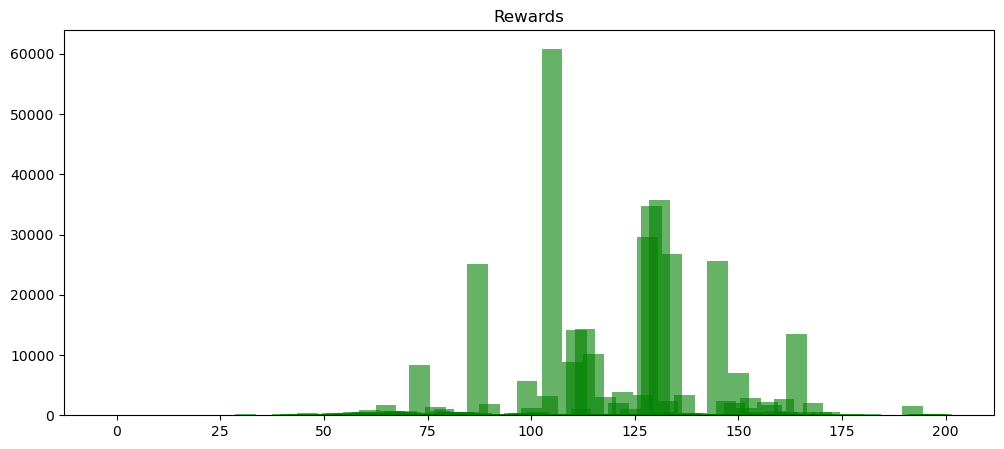

Finished after steps: 146
Finished after steps: 149
Finished after steps: 143
Finished after steps: 143
Finished after steps: 148
Finished after steps: 141
Finished after steps: 145
Finished after steps: 145
Finished after steps: 150
Finished after steps: 145


In [1]:
import torch                          
import torch.nn as nn                 
import torch.optim as optim           
import gym                            
import random                        
import math                          
import time                           

import matplotlib.pyplot as plt       

use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor
LongTensor = torch.LongTensor

env = gym.make('CartPole-v1')

seed_value = 23
torch.manual_seed(seed_value)
random.seed(seed_value)


learning_rate = 0.001
num_episodes = 200
gamma = 0.99

hidden_layer = 256

replay_mem_size = 200000
batch_size = 128

egreedy = 1
egreedy_final = 0.01
egreedy_decay = 2000

report_interval = 10
score_to_solve = 195

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n 

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

class NeuralNetwork(nn.Module): 
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer) 
        self.linear2 = nn.Linear(hidden_layer,number_of_outputs) 
        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
             
    def forward(self, x):
        output1 = self.linear1(x) 
        output1 = self.activation(output1)
        output2 = self.linear2(output1)

        return output2
  
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.loss_func = nn.MSELoss()      
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)

        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon: 
            
            with torch.no_grad(): 
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state) 
                action = torch.max(action_from_nn,0)[1]
                action = action.item()
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self):
        
        if (len(memory) < batch_size):
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = Tensor(state).to(device) 
        new_state = Tensor(new_state).to(device)
        reward = Tensor(reward).to(device)
        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)

        new_state_values = self.nn(new_state).detach()
        max_new_state_values = torch.max(new_state_values, 1)[0]
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
 
class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
 
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory): 
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        self.position = ( self.position + 1 ) % self.capacity
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):
        return len(self.memory)
        

memory = ExperienceReplay(replay_mem_size)
qnet_agent = QNet_Agent()
qnet_agent.nn.eval()
env = gym.make('CartPole-v1', render_mode = 'human')
for episode in range(10):
    state, _ = env.reset()
    time.sleep(1.) 
    for step in range(10000):
        env.render() 
        time.sleep(0.02) 
        action = qnet_agent.select_action(state, 0)
        new_state, reward, done, _, _ = env.step(action)
        state = new_state
        if done:
            print('Finished after steps:', step)
            break
    
    break
env.close()
env.env.close()

env = gym.make('CartPole-v1')

qnet_agent.nn.train()

steps_total = [] 

frames_total = 0 
solved_after = 0 
solved = False

start_time = time.time()

for i_episode in range(num_episodes):

    state, _ = env.reset()
    
    step = 0 

    while True: 
        
        step += 1 
        frames_total += 1 
        
        epsilon = calculate_epsilon(frames_total) 
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon) 
        
        new_state, reward, done, _, _ = env.step(action) 

        memory.push(state, action, new_state, reward, done) 
        qnet_agent.optimize() 
        
        state = new_state 
         
        if done: 
            steps_total.append(step) 
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  ) 
                  
                elapsed_time = time.time() - start_time
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



            break
        
state_dict = qnet_agent.nn.state_dict()
torch.save(state_dict, 'dqn_er_best14.pth')


print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green', width=5)
plt.show()


env.close()
env.env.close()


state_dict = torch.load('dqn_er_best14.pth')
qnet_agent.nn.load_state_dict(state_dict)
qnet_agent.nn.eval()
env = gym.make('CartPole-v1', render_mode = 'human')
for episode in range(10):
    state, _ = env.reset()
    time.sleep(1.) 
    for step in range(10000):
        env.render() 
        time.sleep(0.02) 
        action = qnet_agent.select_action(state, 0)
        new_state, reward, done, _, _ = env.step(action)
        state = new_state
        if done:
            print('Finished after steps:', step)
            break
env.close()
env.env.close()

# Explanation of Results

Key points from results:

The algorithm solved the problem after 73 episodes, which is little bit slower compared to the previous two tests.
The average reward across all episodes was 2038.34 which is a huge rise from the previous test.
The average reward across the last 100 episodes was 3400.10.

Comparing with the previous tests:

This test results solved the problem in 73 episodes, indicating that the algorithm performed well.
The set of results had a higher average reward across all episodes (2038.34 compared to 1330.33 and 383.64), indicating that the algorithm performed best overall.

This set of results also had a higher average reward across the last 100 episodes (3400.10 compared to 1657.47 and 383.64), indicating that the algorithm's performance improved very well over time.

In general, this set of results shows that the algorithm performed best than the previous tests and was able to solve the problem more efficiently than the first set of results. It had higher average rewards across all episodes and the last 100 episodes. It did take around 14 minutes to solve the problem and the main reason to this could be the learning rate.

# Conclusion

The code used is a reinforcement learning algorithm that uses a Q-learning approach to train an agent to play the CartPole-v1 game from the gym library. The Q-learning approach is implemented using a neural network to estimate the Q-value function, and experience replay to store and sample the transitions of the agent from the environment. The algorithm also uses an epsilon-greedy policy to balance exploration and exploitation during the training process. The training process is stopped if the agent achieves an average score of 195 over 100 consecutive episodes, which is the score needed to solve the CartPole-v1 game. The final output of the algorithm is the number of steps taken by the agent to solve the game.

Apart from the intial test, I did 2 different tests with different hyperparameter values to compare results, and in general changing the values of hyperparameters affected the results hugely. However all 3 tests were successful as they were able to solve the problem and the agent was able to achieve an average score of 195 over 100 consecutive episodes for all 3 tests. The second test was able to solve the problem in minimal number of episodes (35) however the third test which took a relatively longer time to solve produced an average reward of 2038 and 3400 for average reward (last 100 episodes) which is an incredible score. 

In conclusion, I was able to successfully complete the task, by adding comments, changing hyperparameter values to obtain the best results. The following are the best hyperparameters for best results from all 3 tests:

learning_rate = 0.01
num_episodes = 150
gamma = 0.99

hidden_layer = 128

replay_mem_size = 100000
batch_size = 64

egreedy = 0.99
egreedy_final = 0.05
egreedy_decay = 1000

In future there is still room for improvement as more different tests could be performed which could lead to more critical analysis and comparisons. This may be time consuming, however it is certain that changing the parameters greatly affects the results.